In [ ]:
import pandas as pd
import numpy as np
import folium
import branca.colormap as cm
from sklearn.datasets import fetch_california_housing
np.set_printoptions(precision=4)

## 데이터 셋 가져오기

In [ ]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()

print(data.DESCR)

**컬럼 소개 (California Housing Dataset)**

속성 수 : 8

* **MedInc**: 블록 그룹의 중간 소득
* **HouseAge**: 블록 그룹의 중간 주택 연령
* **AveRooms**: 가구당 평균 방 수
* **AveBedrms**: 가구당 평균 침실 수
* **Population**: 블록 그룹 인구
* **AveOccup**: 가구당 평균 거주자 수
* **Latitude**: 블록 그룹 위도
* **Longitude**: 블록 그룹 경도
* **MedHouseVal**: 중간 주택 가격 (타겟, $100,000 단위)

## 데이터프레임으로 만들기

In [ ]:
df = pd.DataFrame(data['data'], columns=data['feature_names'])

In [ ]:
# California Housing의 타겟 컬럼명은 'MedHouseVal' (중간 주택 가격)
df['MedHouseVal'] = data['target']

In [ ]:
df.describe()

## 지도 위에 시각화

In [ ]:
# 위도, 경도의 평균을 중심으로 지도 생성
center = [df['Latitude'].mean(), df['Longitude'].mean()]
m = folium.Map(location=center, zoom_start=6)

# 데이터가 많으므로 일부만 샘플링하여 시각화 (예: 1000개)
sample_df = df.sample(n=1000, random_state=42)

# 가격에 따른 색상 매핑 함수 (Linear Colormap)
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'red'], 
                             index=[sample_df['MedHouseVal'].min(), sample_df['MedHouseVal'].max()],
                             vmin=sample_df['MedHouseVal'].min(),
                             vmax=sample_df['MedHouseVal'].max())
colormap.caption = 'Median House Value'
colormap.add_to(m)

for idx, row in sample_df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,  # 반지름은 고정 (가격과 무관)
        color=colormap(row['MedHouseVal']),
        fill=True,
        fill_color=colormap(row['MedHouseVal']),
        fill_opacity=0.7,
        tooltip=f"Price: {row['MedHouseVal']}"
    ).add_to(m)



In [ ]:
m

## 데이터를 분할 (train_test_split)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('MedHouseVal', axis=1), df['MedHouseVal'], test_size=0.2, random_state=42)

X_train.shape, X_test.shape

### 평가지표(MSE,MAE,RMSE,R2)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

# plot_predictions : 예측값과 실제값을 산점도로 비교하여 시각화
def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': actual})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

# mse 기준으로 모델의 성능 평가를 해주는 함수
def mse_eval(name_, pred, actual):
    global predictions
    global colors

    # 산점도를 그려주고(예측값, 정답값)
    plot_predictions(name_, pred, actual)

    # mse 계산 출력
    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    # 모델별 성능을 비교하기 위해 sorted
    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    # 모델들을 비교해서 barh로 그려준다.
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

# 리스트에 있는 모델중에 하나를 삭제하는 함수
def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

## LinearRegression

In [ ]:
# 1. 모델 생성
linear_reg = LinearRegression(n_jobs=-1)

# 2. 모델 학습
linear_reg.fit(X_train, y_train)

# 3. 모델 예측
pred = linear_reg.predict(X_test)

# 4. 모델 평가
mse_eval('LinearRegression', pred, y_test)

## Ridge

In [ ]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
mse_eval('Ridge(alpha=1)', pred, y_test)

##  Lasso

In [ ]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
pred = lasso.predict(X_test)
mse_eval('Lasso(alpha=0.01)', pred, y_test)

## ElasticNet

In [ ]:
elasticnet = ElasticNet(alpha=0.5, l1_ratio=0.1)
elasticnet.fit(X_train, y_train)
pred = elasticnet.predict(X_test)
mse_eval('ElasticNet(alpha=0.5, l1_ratio=0.1)', pred, y_test)    

## Pipeline

In [ ]:
elasticnet_pipeline = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=0.1, l1_ratio=0.1)
)
elasticnet_pred = elasticnet_pipeline.fit(X_train, y_train).predict(X_test)
mse_eval('Standard ElasticNet', elasticnet_pred, y_test)

## 앙상블 모델

### Voting Regressor

In [ ]:
from sklearn.ensemble import VotingRegressor, VotingClassifier

In [ ]:
from sklearn.ensemble import VotingRegressor

# 앞에서 학습이 완료된 모델을 가져오기
single_models = [ 
    ('lasso', lasso),
    ('ridge', ridge),
    ('linear_reg',linear_reg),
    ('std_elastic', elasticnet_pipeline)
]

# 모델 생성
voting_reg = VotingRegressor(single_models, n_jobs=-1)

# 모델 학습
voting_reg.fit(X_train, y_train)



In [ ]:
# 모델 예측
y_pred = voting_reg.predict(X_test)

# 모델 평가
mse_eval('voting_regressor',y_pred, y_test)

## Bagging 방식의 앙상블
Bootstrap, AGGregating : 약어 합쳐서 Bagging 

### random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
rf_reg = RandomForestRegressor()

# 모델 학습
rf_reg.fit(X_train, y_train)

In [ ]:
rf_reg_pred = rf_reg.predict(X_test)
mse_eval('RandomForest Ensemble', rf_reg_pred, y_test)

## GridSearchCV로 rf_reg를 하이퍼파라메터 튜닝
AutoML 혹은 자동 하이퍼파라메터 튜닝 : optuna, H2o, autogluon

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 1.RF 모델 생성
rf_reg_cv = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [500,600,700,800,900],
    'max_depth': [None]
    }
# GridSearchCV 모델 생성
grid_rg_reg = GridSearchCV(rf_reg_cv, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 2.모델 학습
grid_rg_reg.fit(X_train, y_train)

In [ ]:
scores_df = pd.DataFrame(grid_rg_reg.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score', 'split4_test_score']]

In [ ]:
print('GridSearch 최적 파라미터: ', grid_rg_reg.best_params_)
print('GridSearch 최고 점수: ', grid_rg_reg.best_score_)

In [ ]:
# 3. 모델 예측
y_pred = grid_rg_reg.predict(X_test)

# 4. 모델 평가
mse_eval('RF GridSearchCV', y_pred, y_test)

## 부스팅 모델
GBM, AdaBoost, XGBoost, LightGBM

In [ ]:
from IPython.display import Image
Image('https://keras.io/img/graph-kaggle-1.jpeg', width=800)

## GBM

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

#1. 모델 생성
gbr = GradientBoostingRegressor(max_depth = 2, n_estimators = 200, learning_rate = 0.1, random_state = 42)

# 2. 모델 학습
gbr.fit(X_train, y_train)



In [ ]:

# 모델 예측
y_pred = gbr.predict(X_test)

# 모델 평가
mse_eval('gbr',y_pred, y_test)

In [ ]:
import numpy as np

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

## XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb_reg = XGBRegressor(random_state = 42, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.8)

xgb_reg.fit(X_train, y_train)


In [ ]:
# 모델 예측
y_pred = xgb_reg.predict(X_test)

# 모델 평가
mse_eval('xgb_regressor',y_pred, y_test)

## LGBM Regressor

In [ ]:
from lightgbm import LGBMRegressor

lgbm_reg = LGBMRegressor(random_state = 42, learning_rate = 0.05, n_estimators = 1000, colsample_bytree=0.9, num_leaves=31,            # 늘리면 더 복잡한 모델 (너무 크면 과적합 주의)
    min_child_samples=10,     # 줄이면 더 미세한 분기 가능 (기본값 20)
    min_child_weight=0.001,   # 줄이면 더 작은 단위로 분기
    verbose=-1  )

lgbm_reg.fit(X_train, y_train)

In [ ]:
# 모델 예측
y_pred = lgbm_reg.predict(X_test)

# 모델 평가
mse_eval('lgbm_regressor',y_pred, y_test)

## Stacking

In [38]:
from sklearn.ensemble import StackingRegressor

stack_models = [
    ('rf', rf_reg), 
    ('xgb', xgb_reg), 
    ('gbr', gbr),
    ('lgbm', lgbm_reg),
]

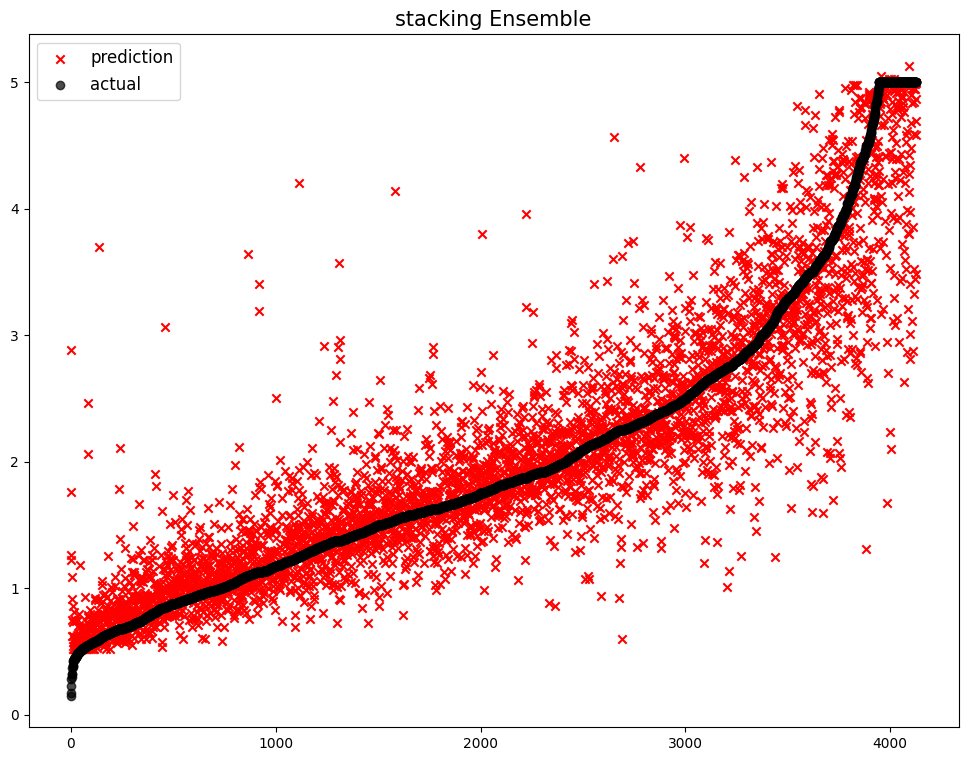

                                  model       mse
0   ElasticNet(alpha=0.5, l1_ratio=0.1)  0.616577
1                   Standard ElasticNet  0.590975
2                      LinearRegression  0.555892
3                        Ridge(alpha=1)  0.555892
4                      voting_regressor  0.548854
5                     Lasso(alpha=0.01)  0.544449
6                                   gbr  0.302871
7                 RandomForest Ensemble  0.255216
8                       RF GridSearchCV  0.252204
9                     stacking Ensemble  0.226299
10                       lgbm_regressor  0.222590
11                        xgb_regressor  0.209973


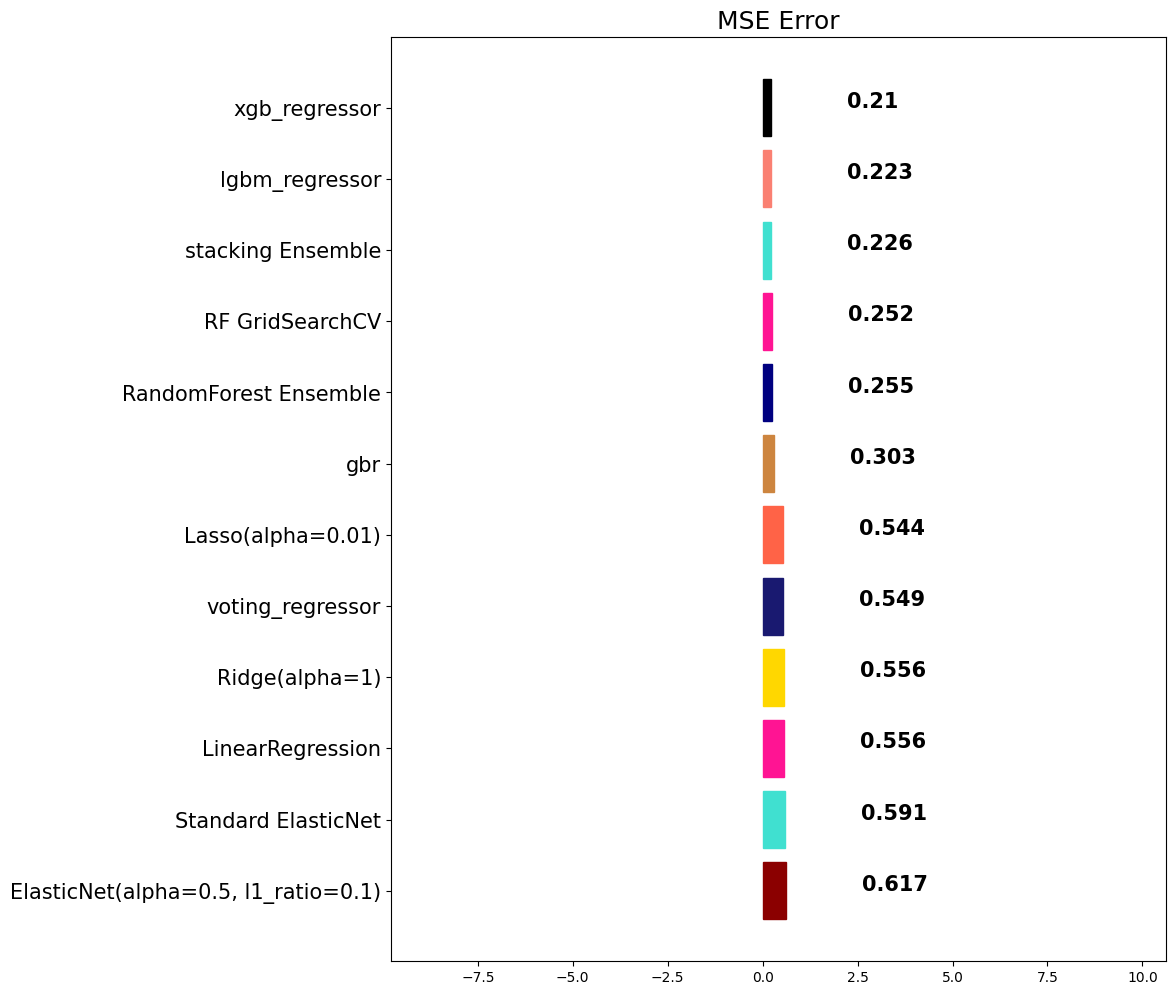

In [40]:
# 1.모델 생성
stack_reg = StackingRegressor(estimators=stack_models, final_estimator=lgbm_reg)

# 2.모델 학습
stack_reg.fit(X_train, y_train)

# 3.모델 예측
y_pred = stack_reg.predict(X_test)

# 4. 모델 평가
mse_eval('stacking Ensemble', y_pred, y_test)